In [2]:
# Input data files are available in the "../input/" directory.
import os
for dirname, _, filenames in os.walk('input'):
    filenames.sort()
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
%%time
datadir = Path('../input/covid19')

# Read in the data CSV files
train = pd.read_csv(datadir/'train.csv')
test = pd.read_csv(datadir/'test.csv')
submission = pd.read_csv(datadir/'submission.csv')


Wall time: 39.9 ms


In [4]:
train

Id Province_State Country_Region        Date  ConfirmedCases  \
0          1            NaN    Afghanistan  2020-01-22             0.0   
1          2            NaN    Afghanistan  2020-01-23             0.0   
2          3            NaN    Afghanistan  2020-01-24             0.0   
3          4            NaN    Afghanistan  2020-01-25             0.0   
4          5            NaN    Afghanistan  2020-01-26             0.0   
...      ...            ...            ...         ...             ...   
26287  35648            NaN       Zimbabwe  2020-04-10            13.0   
26288  35649            NaN       Zimbabwe  2020-04-11            14.0   
26289  35650            NaN       Zimbabwe  2020-04-12            14.0   
26290  35651            NaN       Zimbabwe  2020-04-13            17.0   
26291  35652            NaN       Zimbabwe  2020-04-14            17.0   

       Fatalities  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
26287         3.0  
26288         3.0  
26289         3.0  
26290         3.0  
26291         3.0  

[26292 rows x 6 columns]

In [5]:
test

ForecastId Province_State Country_Region        Date
0               1            NaN    Afghanistan  2020-04-02
1               2            NaN    Afghanistan  2020-04-03
2               3            NaN    Afghanistan  2020-04-04
3               4            NaN    Afghanistan  2020-04-05
4               5            NaN    Afghanistan  2020-04-06
...           ...            ...            ...         ...
13454       13455            NaN       Zimbabwe  2020-05-10
13455       13456            NaN       Zimbabwe  2020-05-11
13456       13457            NaN       Zimbabwe  2020-05-12
13457       13458            NaN       Zimbabwe  2020-05-13
13458       13459            NaN       Zimbabwe  2020-05-14

[13459 rows x 4 columns]

In [6]:
submission

ForecastId  ConfirmedCases  Fatalities
0               1               1           1
1               2               1           1
2               3               1           1
3               4               1           1
4               5               1           1
...           ...             ...         ...
13454       13455               1           1
13455       13456               1           1
13456       13457               1           1
13457       13458               1           1
13458       13459               1           1

[13459 rows x 3 columns]

In [7]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Fatalities': 'fatalities'}, axis=1, inplace=True)
test.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Fatalities': 'fatalities'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')
test['country_province'] = test['country'].fillna('') + '/' + test['province'].fillna('')

<a id="id_ww"></a>
# Worldwide trend

In [8]:
ww_df = train.groupby('date')[['confirmed', 'fatalities']].sum().reset_index()
ww_df['new_case'] = ww_df['confirmed'] - ww_df['confirmed'].shift(1)
ww_df.tail()

date  confirmed  fatalities  new_case
79  2020-04-10  1691542.0    102519.0   96368.0
80  2020-04-11  1771337.0    108497.0   79795.0
81  2020-04-12  1846503.0    114088.0   75166.0
82  2020-04-13  1917143.0    119481.0   70640.0
83  2020-04-14  1973538.0    125908.0   56395.0

In [9]:
ww_melt_df = pd.melt(ww_df, id_vars=['date'], value_vars=['confirmed', 'fatalities', 'new_case'])
ww_melt_df

date   variable    value
0    2020-01-22  confirmed    554.0
1    2020-01-23  confirmed    653.0
2    2020-01-24  confirmed    939.0
3    2020-01-25  confirmed   1432.0
4    2020-01-26  confirmed   2113.0
..          ...        ...      ...
247  2020-04-10   new_case  96368.0
248  2020-04-11   new_case  79795.0
249  2020-04-12   new_case  75166.0
250  2020-04-13   new_case  70640.0
251  2020-04-14   new_case  56395.0

[252 rows x 3 columns]

In [10]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable', 
              title="Worldwide Confirmed/Death Cases Over Time")
fig.show()

In [11]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable',
              title="Worldwide Confirmed/Death Cases Over Time (Log scale)",
             log_y=True)
fig.show()

In [12]:
ww_df['mortality'] = ww_df['fatalities'] / ww_df['confirmed']

fig = px.line(ww_df, x="date", y="mortality", 
              title="Worldwide Mortality Rate Over Time")
fig.show()

In [ ]:
<a id="id_country"></a>
# Country-wise growth

In [13]:
country_df = train.groupby(['date', 'country'])[['confirmed', 'fatalities']].sum().reset_index()
country_df.tail()

date             country  confirmed  fatalities
15451  2020-04-14             Vietnam      266.0         0.0
15452  2020-04-14  West Bank and Gaza      308.0         2.0
15453  2020-04-14      Western Sahara        6.0         0.0
15454  2020-04-14              Zambia       45.0         2.0
15455  2020-04-14            Zimbabwe       17.0         3.0

What kind of country is in the dataset? How's the distribution of number of confirmed cases by country?

In [14]:
countries = country_df['country'].unique()
print(f'{len(countries)} countries are in dataset:\n{countries}')

184 countries are in dataset:
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' '

In [15]:
target_date = country_df['date'].max()

print('Date: ', target_date)
for i in [1, 10, 100, 1000, 10000]:
    n_countries = len(country_df.query('(date == @target_date) & confirmed > @i'))
    print(f'{n_countries} countries have more than {i} confirmed cases')

Date:  2020-04-14
184 countries have more than 1 confirmed cases
171 countries have more than 10 confirmed cases
123 countries have more than 100 confirmed cases
73 countries have more than 1000 confirmed cases
23 countries have more than 10000 confirmed cases


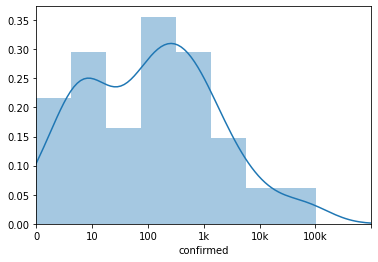

In [16]:
ax = sns.distplot(np.log10(country_df.query('date == "2020-03-27"')['confirmed'] + 1))
ax.set_xlim([0, 6])
ax.set_xticks(np.arange(7))
_ = ax.set_xticklabels(['0', '10', '100', '1k', '10k', '100k'])

In [17]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 1000)').sort_values('confirmed', ascending=False)
top_country_melt_df = pd.melt(top_country_df, id_vars='country', value_vars=['confirmed', 'fatalities'])

In [18]:
fig = px.bar(top_country_melt_df.iloc[::-1],
             x='value',
             y='country',
             color='variable',
             barmode='group',
             title=f'Confirmed Cases/Deaths on {target_date}',
             text='value',
             height=1500,
             orientation='h')
fig.show()

In [19]:
top30_countries = top_country_df.sort_values(
    'confirmed', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date',
              y='confirmed',
              color='country',
              title=f'Confirmed Cases for top 30 country as of {target_date}')
fig.show()

In [20]:
top30_countries = top_country_df.sort_values('fatalities', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date', y='fatalities', color='country',
              title=f'Fatalities for top 30 country as of {target_date}')
fig.show()

In [21]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 100)')
top_country_df['mortality_rate'] = top_country_df['fatalities'] / top_country_df['confirmed']
top_country_df = top_country_df.sort_values('mortality_rate', ascending=False)

In [ ]:
fig = px.bar(top_country_df[:30].iloc[::-1],
             x='mortality_rate',
             y='country',
             title=f'Mortality rate HIGH: top 30 countries on {target_date}',
             text='mortality_rate',
             height=800,
             orientation='h')
fig.show()

In [23]:
fig = px.bar(top_country_df[-30:],
             x='mortality_rate', y='country',
             title=f'Mortality rate LOW: top 30 countries on {target_date}', text='mortality_rate', height=800, orientation='h')
fig.show()

In [24]:
all_country_df = country_df.query('date == @target_date')
all_country_df['confirmed_log1p'] = np.log10(all_country_df['confirmed'] + 1)
all_country_df['fatalities_log1p'] = np.log10(all_country_df['fatalities'] + 1)
all_country_df['mortality_rate'] = all_country_df['fatalities'] / all_country_df['confirmed']

In [25]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="confirmed_log1p", 
                    hover_name="country", hover_data=["confirmed", 'fatalities', 'mortality_rate'],
                    range_color=[all_country_df['confirmed_log1p'].min(), all_country_df['confirmed_log1p'].max()], 
                    color_continuous_scale="peach", 
                    title='Countries with Confirmed Cases')

# I'd like to update colorbar to show raw values, but this does not work somehow...
# Please let me know if you know how to do this!!
trace1 = list(fig.select_traces())[0]
trace1.colorbar = go.choropleth.ColorBar(
    tickvals=[0, 1, 2, 3, 4, 5],
    ticktext=['1', '10', '100', '1000','10000', '10000'])
fig.show()

In [26]:

fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="fatalities_log1p", 
                    hover_name="country", range_color=[0, 4],
                    hover_data=['confirmed', 'fatalities', 'mortality_rate'],
                    color_continuous_scale="peach", 
                    title='Countries with fatalities')
fig.show()

In [27]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="mortality_rate", 
                    hover_name="country", range_color=[0, 0.12], 
                    color_continuous_scale="peach", 
                    title='Countries with mortality rate')
fig.show()

In [28]:
n_countries = 20
n_start_death = 10
fatality_top_countires = top_country_df.sort_values('fatalities', ascending=False).iloc[:n_countries]['country'].values
country_df['date'] = pd.to_datetime(country_df['date'])


df_list = []
for country in fatality_top_countires:
    this_country_df = country_df.query('country == @country')
    start_date = this_country_df.query('fatalities > @n_start_death')['date'].min()
    this_country_df = this_country_df.query('date >= @start_date')
    this_country_df['date_since'] = this_country_df['date'] - start_date
    this_country_df['fatalities_log1p'] = np.log10(this_country_df['fatalities'] + 1)
    this_country_df['fatalities_log1p'] -= this_country_df['fatalities_log1p'].values[0]
    df_list.append(this_country_df)

tmpdf = pd.concat(df_list)
tmpdf['date_since_days'] = tmpdf['date_since'] / pd.Timedelta('1 days')

In [29]:
fig = px.line(tmpdf,
              x='date_since_days', y='fatalities_log1p', color='country',
              title=f'Fatalities by country since 10 deaths, as of {target_date}')
fig.add_trace(go.Scatter(x=[0, 21], y=[0, 3], name='Double by 7 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 42], y=[0, 3], name='Double by 14 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 63], y=[0, 3], name='Double by 21 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.show()

In [30]:
country_df['prev_confirmed'] = country_df.groupby('country')['confirmed'].shift(1)
country_df['new_case'] = country_df['confirmed'] - country_df['prev_confirmed']
country_df['new_case'].fillna(0, inplace=True)
top30_country_df = country_df[country_df['country'].isin(top30_countries)]

fig = px.line(top30_country_df,
              x='date', y='new_case', color='country',
              title=f'DAILY NEW Confirmed cases world wide')
fig.show()

In [31]:
country_df['date'] = country_df['date'].apply(str)
country_df['confirmed_log1p'] = np.log1p(country_df['confirmed'])
country_df['fatalities_log1p'] = np.log1p(country_df['fatalities'])

fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="confirmed", size='confirmed', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['confirmed'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Confirmed cases spread Over Time', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

In [32]:
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="fatalities", size='fatalities', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['fatalities'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Fatalities growth Over Time', color_continuous_scale="portland")
fig.show()

In [33]:
country_df.loc[country_df['new_case'] < 0, 'new_case'] = 0.
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="new_case", size='new_case', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['new_case'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Daily NEW cases over Time', color_continuous_scale="portland")
fig.show()

In [34]:
for country in countries:
    province = train.query('country == @country')['province'].unique()
    if len(province) > 1:       
        print(f'Country {country} has {len(province)} provinces: {province}')

Country Australia has 8 provinces: ['Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia']
Country Canada has 12 provinces: ['Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon']
Country China has 33 provinces: ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
Country Denmark has 3 provinces: ['Faroe Islands' 'Greenland' nan]
Country France has 11 provinces: ['French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique' 'Mayotte'
 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'Saint P

In [42]:
usa_state_code_df = pd.read_csv('../input/covid19/usa_states2.csv')

In [43]:
# Prepare data frame only for US. 

train_us = train.query('country == "US"')
train_us['mortality_rate'] = train_us['fatalities'] / train_us['confirmed']

# Convert province column to its 2-char code name,
state_name_to_code = dict(zip(usa_state_code_df['state_name'], usa_state_code_df['state_code']))
train_us['province_code'] = train_us['province'].map(state_name_to_code)

# Only show latest days.
train_us_latest = train_us.query('date == @target_date')

In [44]:
fig = px.choropleth(train_us_latest,
                    locations='province_code',
                    locationmode="USA-states",
                    color='confirmed',
                    scope="usa",
                    hover_data=['province', 'fatalities', 'mortality_rate'],
                    title=f'Confirmed cases in US on {target_date}')
fig.show()

In [46]:
fig = px.choropleth(train_us_latest, locations='province_code', locationmode="USA-states",
                    color='mortality_rate', scope="usa", hover_data=['province', 'fatalities', 'mortality_rate'],
                    title=f'Mortality rate in US on {target_date}')
fig.show()

In [47]:
train_us_march = train_us.query('date > "2020-03-01"')
fig = px.line(train_us_march,
              x='date', y='confirmed', color='province',
              title=f'Confirmed cases by state in US, as of {target_date}')
fig.show()

In [48]:
# Ref: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

country_df['date'] = pd.to_datetime(country_df['date'])
train_europe = country_df[country_df['country'].isin(europe_country_list)]
#train_europe['date_str'] = pd.to_datetime(train_europe['date'])
train_europe_latest = train_europe.query('date == @target_date')

In [49]:
fig = px.choropleth(
    train_europe_latest,
    locations="country",
    locationmode='country names',
    color="confirmed",
    hover_name="country",
    range_color=[1, train_europe_latest['confirmed'].max()],
    color_continuous_scale='portland',
    title=f'European Countries with Confirmed Cases as of {target_date}',
    scope='europe',
    height=800)
fig.show()

In [50]:
train_europe_march = train_europe.query('date >= "2020-03-01"')
fig = px.line(train_europe_march,
              x='date', y='confirmed', color='country',
              title=f'Confirmed cases by country in Europe, as of {target_date}')
fig.show()

In [51]:
fig = px.line(train_europe_march,
              x='date', y='fatalities', color='country',
              title=f'Fatalities by country in Europe, as of {target_date}')
fig.show()

In [52]:
train_europe_march['prev_confirmed'] = train_europe_march.groupby('country')['confirmed'].shift(1)
train_europe_march['new_case'] = train_europe_march['confirmed'] - train_europe_march['prev_confirmed']
fig = px.line(train_europe_march,
              x='date', y='new_case', color='country',
              title=f'DAILY NEW Confirmed cases by country in Europe')
fig.show()

<a id="id_asia"></a>
# Asia

In [53]:
country_latest = country_df.query('date == @target_date')

fig = px.choropleth(
    country_latest,
    locations="country",
    locationmode='country names',
    color="confirmed",
    hover_name="country",
    range_color=[1, 50000],
    color_continuous_scale='portland',
    title=f'Asian Countries with Confirmed Cases as of {target_date}',
    scope='asia',
    height=800)
fig.show()

In [54]:
top_asian_country_df = country_df[country_df['country'].isin([
    'China', 'Indonesia', 'Iran', 'Japan', 'Korea, South', 'Malaysia',
    'Philippines'
])]

fig = px.line(top_asian_country_df,
              x='date',
              y='new_case',
              color='country',
              title=f'DAILY NEW Confirmed cases world wide')
fig.show()

<a id="id_recover"></a>
# Which country is recovering now?

In [55]:
max_confirmed = country_df.groupby('country')['new_case'].max().reset_index()
country_latest = pd.merge(country_latest, max_confirmed.rename({'new_case': 'max_new_case'}, axis=1))
country_latest['new_case_peak_to_now_ratio'] = country_latest['new_case'] / country_latest['max_new_case']

In [56]:
recovering_country = country_latest.query('new_case_peak_to_now_ratio < 0.5')
major_recovering_country = recovering_country.query('confirmed > 100')

In [57]:
fig = px.bar(major_recovering_country.sort_values('new_case_peak_to_now_ratio',
                                                  ascending=False),
             x='new_case_peak_to_now_ratio',
             y='country',
             title=f'Mortality rate LOW: top 30 countries on {target_date}',
             text='new_case_peak_to_now_ratio',
             height=1000,
             orientation='h')
fig.show()

In [58]:
fig = px.choropleth(
    country_latest,
    locations="country",
    locationmode='country names',
    color="new_case_peak_to_now_ratio",
    hover_name="country",
    range_color=[0, 1],
    # color_continuous_scale="peach",
    hover_data=['confirmed', 'fatalities', 'new_case', 'max_new_case'],
    title='Countries with new_case_peak_to_now_ratio')
fig.show()

In [59]:
china_df = train.query('country == "China"')
china_df['prev_confirmed'] = china_df.groupby('country')['confirmed'].shift(1)
china_df['new_case'] = china_df['confirmed'] - china_df['prev_confirmed']
china_df.loc[china_df['new_case'] < 0, 'new_case'] = 0.

In [60]:
fig = px.line(china_df,
              x='date', y='new_case', color='province',
              title=f'DAILY NEW Confirmed cases in China by province')
fig.show()

In [61]:
china_df.query('(province == "Hubei") & (date > "2020-03-10")')

id province country        date  confirmed  fatalities  \
5677  7688    Hubei   China  2020-03-11    67773.0      3046.0   
5678  7689    Hubei   China  2020-03-12    67781.0      3056.0   
5679  7690    Hubei   China  2020-03-13    67786.0      3062.0   
5680  7691    Hubei   China  2020-03-14    67790.0      3075.0   
5681  7692    Hubei   China  2020-03-15    67794.0      3085.0   
5682  7693    Hubei   China  2020-03-16    67798.0      3099.0   
5683  7694    Hubei   China  2020-03-17    67799.0      3111.0   
5684  7695    Hubei   China  2020-03-18    67800.0      3122.0   
5685  7696    Hubei   China  2020-03-19    67800.0      3130.0   
5686  7697    Hubei   China  2020-03-20    67800.0      3133.0   
5687  7698    Hubei   China  2020-03-21    67800.0      3139.0   
5688  7699    Hubei   China  2020-03-22    67800.0      3153.0   
5689  7700    Hubei   China  2020-03-23    67800.0      3153.0   
5690  7701    Hubei   China  2020-03-24    67801.0      3160.0   
5691  7702    Hubei   China  2020-03-25    67801.0      3163.0   
5692  7703    Hubei   China  2020-03-26    67801.0      3169.0   
5693  7704    Hubei   China  2020-03-27    67801.0      3174.0   
5694  7705    Hubei   China  2020-03-28    67801.0      3177.0   
5695  7706    Hubei   China  2020-03-29    67801.0      3182.0   
5696  7707    Hubei   China  2020-03-30    67801.0      3186.0   
5697  7708    Hubei   China  2020-03-31    67801.0      3187.0   
5698  7709    Hubei   China  2020-04-01    67802.0      3193.0   
5699  7710    Hubei   China  2020-04-02    67802.0      3199.0   
5700  7711    Hubei   China  2020-04-03    67802.0      3203.0   
5701  7712    Hubei   China  2020-04-04    67803.0      3207.0   
5702  7713    Hubei   China  2020-04-05    67803.0      3210.0   
5703  7714    Hubei   China  2020-04-06    67803.0      3212.0   
5704  7715    Hubei   China  2020-04-07    67803.0      3212.0   
5705  7716    Hubei   China  2020-04-08    67803.0      3213.0   
5706  7717    Hubei   China  2020-04-09    67803.0      3215.0   
5707  7718    Hubei   China  2020-04-10    67803.0      3216.0   
5708  7719    Hubei   China  2020-04-11    67803.0      3219.0   
5709  7720    Hubei   China  2020-04-12    67803.0      3219.0   
5710  7721    Hubei   China  2020-04-13    67803.0      3221.0   
5711  7722    Hubei   China  2020-04-14    67803.0      3221.0   

     country_province  prev_confirmed  new_case  
5677      China/Hubei         67760.0      13.0  
5678      China/Hubei         67773.0       8.0  
5679      China/Hubei         67781.0       5.0  
5680      China/Hubei         67786.0       4.0  
5681      China/Hubei         67790.0       4.0  
5682      China/Hubei         67794.0       4.0  
5683      China/Hubei         67798.0       1.0  
5684      China/Hubei         67799.0       1.0  
5685      China/Hubei         67800.0       0.0  
5686      China/Hubei         67800.0       0.0  
5687      China/Hubei         67800.0       0.0  
5688      China/Hubei         67800.0       0.0  
5689      China/Hubei         67800.0       0.0  
5690      China/Hubei         67800.0       1.0  
5691      China/Hubei         67801.0       0.0  
5692      China/Hubei         67801.0       0.0  
5693      China/Hubei         67801.0       0.0  
5694      China/Hubei         67801.0       0.0  
5695      China/Hubei         67801.0       0.0  
5696      China/Hubei         67801.0       0.0  
5697      China/Hubei         67801.0       0.0  
5698      China/Hubei         67801.0       1.0  
5699      China/Hubei         67802.0       0.0  
5700      China/Hubei         67802.0       0.0  
5701      China/Hubei         67802.0       1.0  
5702      China/Hubei         67803.0       0.0  
5703      China/Hubei         67803.0       0.0  
5704      China/Hubei         67803.0       0.0  
5705      China/Hubei         67803.0       0.0  
5706      China/Hubei         67803.0       0.0  
5707      China/Hubei         67803.0       0.0  
5708      China/Hubei         6

In [62]:
def sigmoid(t, M, beta, alpha, offset=0):
    alpha += offset
    return M / (1 + np.exp(-beta * (t - alpha)))

def error(x, y, params):
    M, beta, alpha = params
    y_pred = sigmoid(x, M, beta, alpha)
    loss_mse = np.mean((y_pred - y) ** 2)
    return loss_mse

def gen_random_color(min_value=0, max_value=256) -> str:
    """Generate random color for plotly"""
    r, g, b = np.random.randint(min_value, max_value, 3)
    return f'rgb({r},{g},{b})'

In [63]:
def fit_sigmoid(exclude_days=0):
    target_country_df_list = []
    pred_df_list = []
    for target_country in top30_countries:
        print('target_country', target_country)
        # --- Train ---
        target_country_df = country_df.query('country == @target_country')

        #train_start_date = target_country_df['date'].min()
        train_start_date = target_country_df.query('confirmed > 1000')['date'].min()
        train_end_date = pd.to_datetime(target_date) - pd.Timedelta(f'{exclude_days} days')
        target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')
        if len(target_date_df) <= 7:
            print('WARNING: the data is not enough, use 7 more days...')
            train_start_date -= pd.Timedelta('7 days')
            target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')

        confirmed = target_date_df['confirmed'].values
        x = np.arange(len(confirmed))

        lossfun = lambda params: error(x, confirmed, params)
        res = sp.optimize.minimize(lossfun, x0=[np.max(confirmed) * 5, 0.08, len(confirmed) / 3.], method='nelder-mead')
        M, beta, alpha = res.x
        # sigmoid_models[key] = (M, beta, alpha)
        # np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)

        # --- Pred ---
        pred_start_date = target_country_df['date'].min()
        pred_end_date = pd.to_datetime('2020-07-01')
        days = int((pred_end_date - pred_start_date) / pd.Timedelta('1 days'))
        # print('pred start', pred_start_date, 'end', pred_end_date, 'days', days)

        x = np.arange(days)
        offset = (train_start_date - pred_start_date) / pd.Timedelta('1 days')
        print('train_start_date', train_start_date, 'offset', offset, 'params', M, beta, alpha)
        y_pred = sigmoid(x, M, beta, alpha, offset=offset)
        # target_country_df['confirmed_pred'] = y_pred

        all_dates = [pred_start_date + np.timedelta64(x, 'D') for x in range(days)]
        pred_df = pd.DataFrame({
            'date': all_dates,
            'country': target_country,
            'confirmed_pred': y_pred,
        })

        target_country_df_list.append(target_country_df)
        pred_df_list.append(pred_df)
    return target_country_df_list, pred_df_list

In [64]:
def plot_sigmoid_fitting(target_country_df_list, pred_df_list, title=''):
    n_countries = len(top30_countries)

    # --- Plot ---
    fig = go.Figure()

    for i in range(n_countries):
        target_country = top30_countries[i]
        target_country_df = target_country_df_list[i]
        pred_df = pred_df_list[i]
        color = gen_random_color(min_value=20)
        # Prediction
        fig.add_trace(go.Scatter(
            x=pred_df['date'], y=pred_df['confirmed_pred'],
            name=f'{target_country}_pred',
            line=dict(color=color, dash='dash')
        ))

        # Ground truth
        fig.add_trace(go.Scatter(
            x=target_country_df['date'], y=target_country_df['confirmed'],
            mode='markers', name=f'{target_country}_actual',
            line=dict(color=color),
        ))
    fig.update_layout(
        title=title, xaxis_title='Date', yaxis_title='Confirmed cases')
    fig.show()

In [65]:
target_country_df_list, pred_df_list = fit_sigmoid(exclude_days=0)

target_country US
train_start_date 2020-03-11 00:00:00 offset 49.0 params 712998.5281678536 0.1930625098625316 25.572849196749395
target_country Italy
train_start_date 2020-02-29 00:00:00 offset 38.0 params 167376.9144592536 0.14529246460509848 26.922268256737457
target_country Spain
train_start_date 2020-03-09 00:00:00 offset 47.0 params 179847.6902766443 0.18970496283410923 21.362976854368036
target_country France
train_start_date 2020-03-08 00:00:00 offset 46.0 params 163422.38935147814 0.17982844706775744 26.801010295572695
target_country United Kingdom
train_start_date 2020-03-14 00:00:00 offset 52.0 params 129871.64677183403 0.17019992078427748 25.325544209144333
target_country Iran
train_start_date 2020-03-02 00:00:00 offset 40.0 params 93635.40619130213 0.11152823941905052 30.051941757380582
target_country Belgium
train_start_date 2020-03-16 00:00:00 offset 54.0 params 36430.2435919089 0.1711015924272403 18.969867207713293
target_country China
train_start_date 2020-01-25 00:00:

In [66]:
plot_sigmoid_fitting(target_country_df_list,
                     pred_df_list,
                     title='Sigmoid fitting with all latest data')

In [67]:
target_country_df_list, pred_df_list = fit_sigmoid(exclude_days=7)

target_country US
train_start_date 2020-03-11 00:00:00 offset 49.0 params 542387.1667457682 0.22724070574294156 22.773532197843366
target_country Italy
train_start_date 2020-02-29 00:00:00 offset 38.0 params 147715.40033721004 0.16608375783493962 24.87618340114215
target_country Spain
train_start_date 2020-03-09 00:00:00 offset 47.0 params 162243.5062583835 0.21053086441950353 20.0817302108194
target_country France
train_start_date 2020-03-08 00:00:00 offset 46.0 params 325914.34280005546 0.1421988154542227 34.68707622462766
target_country United Kingdom
train_start_date 2020-03-14 00:00:00 offset 52.0 params 89996.40432313013 0.20037653443361753 21.4303873615982
target_country Iran
train_start_date 2020-03-02 00:00:00 offset 40.0 params 115078.58829639899 0.1016709967137705 33.821880011527654
target_country Belgium
train_start_date 2020-03-16 00:00:00 offset 54.0 params 27956.661591176013 0.20774109015805353 15.810355486040233
target_country China
train_start_date 2020-01-25 00:00:00 

In [68]:
plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='Sigmoid fitting without last 7days data')